# Heart Failure Predictionタスク

In [1]:
# import文
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from umap import UMAP
#from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import optuna
from optuna.visualization import plot_optimization_history
optuna.logging.set_verbosity(optuna.logging.WARNING)    # optunaのlogを非表示にする。

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

## A　タスクの概要

**目標**　患者の11の特徴から心臓病か否かを分類する。

データは、`data`ディレクトリに`heart.csv`という名前で準備しています。記録されている特徴量は以下のとおりです。

* Age : 患者の年齢
* Sex : 患者の性別
    * `M`は男性, `F`は女性
* ChestPainType : 筋痛の種類
    * `TA`は典型的狭心症, `ATA`は非典型狭心症, `NAP`は非狭心症の痛み, `ASY`は無症状
* RestingBP : 安静時血圧
* Cholesterol : 血清コレステロール値
* FastingBS : 空腹時血糖値
    * `1`は`FastingBS>1`, `0`はそれ以外
* RestingECG : 安静時心電図結果
    * `Normal`は正常, `ST`はST-T波に異常, `LVH`は左心室肥大の可能性・確定
* MaxHR : 到達最大心拍数
* ExerciseAngina : 運動誘発性狭心症
    * `Y`はあり, `N`はなし
* Oldpeak : うつ状態で測定された数値
* ST_Slope : 運動時のSTピークセグメントの動き
    * `Up`はupsloping, `flat`は平坦, `Down`はdownsloping

心臓病かいなかは`HeartDisease`に`1`が心臓病, `0`が正常として記録されています。

## B　事前準備

### データの読み込み

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

# object型になっている列をstring型にcastしておく
string_col = train.select_dtypes(include = "object").columns
train[string_col] = train[string_col].astype("string")
string_col = test.select_dtypes(include = "object").columns
test[string_col] = test[string_col].astype("string")

print("訓練データのサイズ : ", train.shape)
print("テストデータのサイズ : ", test.shape)

訓練データのサイズ :  (642, 12)
テストデータのサイズ :  (276, 12)


## C　探索的データ分析

出力変数である`HeartDisease`と入力変数の間の関係性を調べていきましょう。最初はあまり難しく考えず

* 各変数の分布を知る。
* 前処理するとよさそうかを考える。

くらいで大丈夫です。ある程度データの様子がわかってきたら、細かいことでもよいので「気づいたことをメモする」と良いと思います。

あくまで経験上の話ですが、データに列として存在しない重要な特徴量を見つけた場合、その特徴量をモデルで抽出しようとせずに、予め変数として作ってモデルに代入したほうがうまく予測できることが多いです。一方、入力変数に不要な変数をたくさん残してしまうと、効果的な特徴量を入れていても予測がうまくいかないことが多いです。

探索的データ分析の最終的な目標は
、どの変数をモデルに入力することで、どのようにモデルが出力変数を予測するのかを事前にイメージすることだと思っておくと良いでしょう。これを**特徴量選択**といいます。

### 患者の基礎データ : 偏り・`HeartDisease`との関係

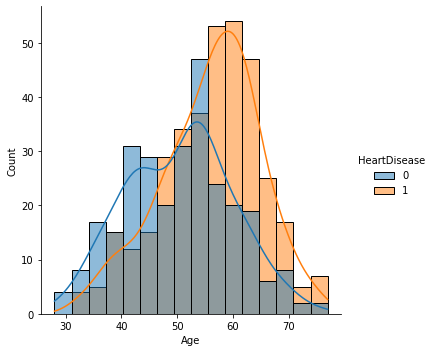

In [3]:
# 年齢の偏り
sns.displot(x = "Age", data = train, hue = "HeartDisease", kde = True)
plt.show()

In [4]:
# 性別の偏り
pd.crosstab(train["Sex"], train["HeartDisease"], margins = "all")

HeartDisease    0    1  All
Sex                        
0             102   35  137
1             181  324  505
All           283  359  642

**考察**

* 年齢が高いほうが心臓病になるリスクが大きいように見えるが、大きな差ではない。
* 男性のほうが女性より心臓病になる人が多い。
* 男性のほうがデータに多く含まれている。

### 量的データと`HeartDisease`との関係

いったん、量的変数に絞って`HeartDisease`との関係を調べます。

#### ヒストグラムと散布図

ヒストグラム（正確にはカーネル密度推定）と散布図を、`HeartDisease`で色分けしたものをかいてみましょう。

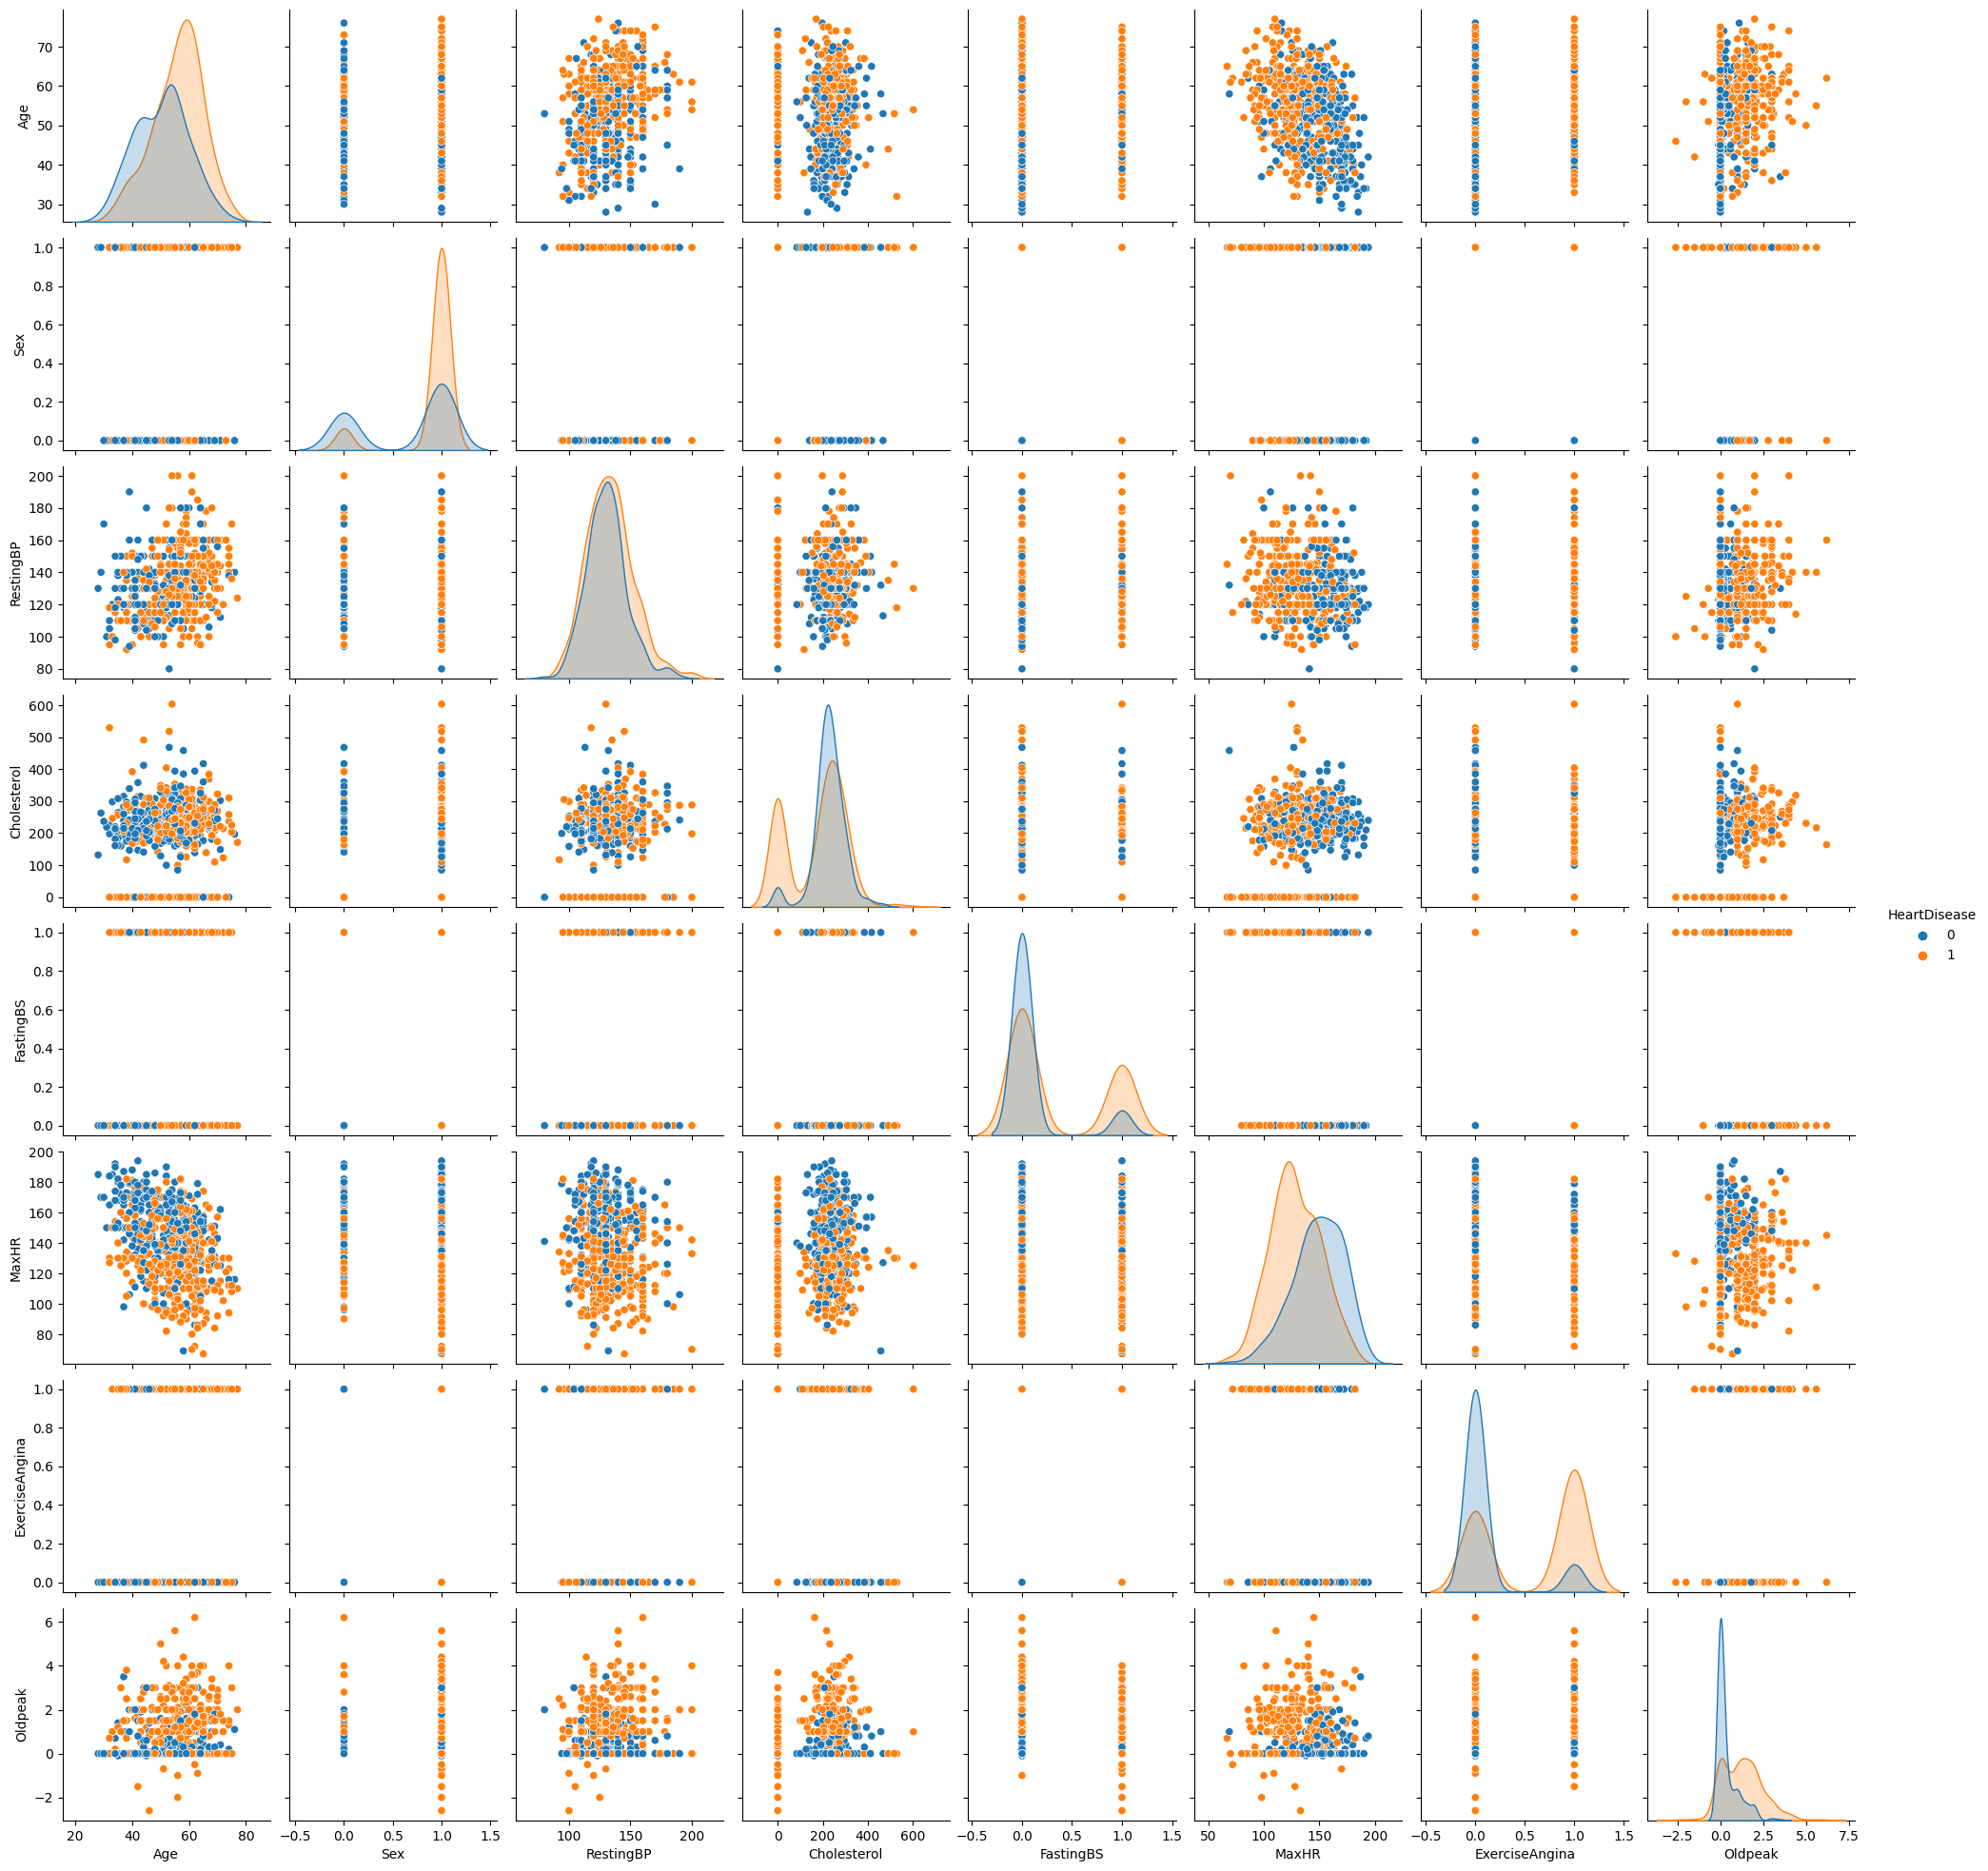

In [5]:
# ヒストグラムと散布図
sns.pairplot(train, hue = "HeartDisease")
plt.show()

In [6]:
train.corr()

Age       Sex  RestingBP  Cholesterol  FastingBS  \
Age             1.000000  0.067057   0.257399    -0.069955   0.211770   
Sex             0.067057  1.000000  -0.022425    -0.186756   0.122689   
RestingBP       0.257399 -0.022425   1.000000     0.124975   0.093639   
Cholesterol    -0.069955 -0.186756   0.124975     1.000000  -0.292057   
FastingBS       0.211770  0.122689   0.093639    -0.292057   1.000000   
MaxHR          -0.399961 -0.187240  -0.088673     0.184904  -0.129337   
ExerciseAngina  0.221435  0.205437   0.143395    -0.057969   0.067225   
Oldpeak         0.263959  0.130622   0.167232     0.038831   0.042604   
HeartDisease    0.294929  0.318622   0.080846    -0.244367   0.284102   

                   MaxHR  ExerciseAngina   Oldpeak  HeartDisease  
Age            -0.399961        0.221435  0.263959      0.294929  
Sex            -0.187240        0.205437  0.130622      0.318622  
RestingBP      -0.088673        0.143395  0.167232      0.080846  
Cholesterol     0.184904       -0.057969  0.038831     -0.244367  
FastingBS      -0.129337        0.067225  0.042604      0.284102  
MaxHR           1.000000       -0.384792 -0.177021     -0.407899  
ExerciseAngina -0.384792        1.000000  0.457348      0.490287  
Oldpeak        -0.177021        0.457348  1.000000      0.417988  
HeartDisease   -0.407899        0.490287  0.417988      1.000000

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_num = ss.fit_transform(train.select_dtypes(exclude = "string").drop("HeartDisease", axis = 1))
pca = PCA(n_components = 2)
pca.fit(X_num)
pca.components_

array([[ 0.43827056,  0.26428585,  0.23095736, -0.18098465,  0.25163409,
        -0.45954174,  0.46727532,  0.39891178],
       [-0.09562418,  0.30483462, -0.39139803, -0.64934995,  0.42016702,
        -0.08951889, -0.17435344, -0.32883281]])

In [8]:
features = train.select_dtypes(exclude = "string").drop("HeartDisease", axis = 1).columns.tolist()
features

['Age',
 'Sex',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak']

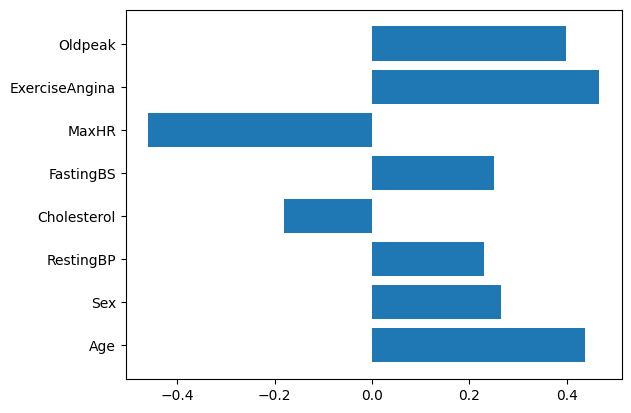

In [9]:
plt.barh(features, pca.components_[0])
plt.show()

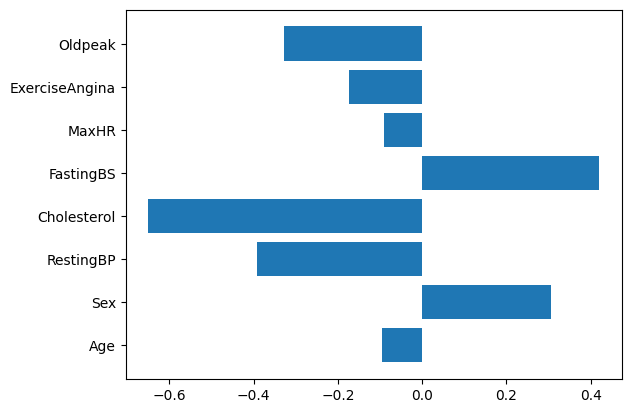

In [10]:
plt.barh(features, pca.components_[1])
plt.show()

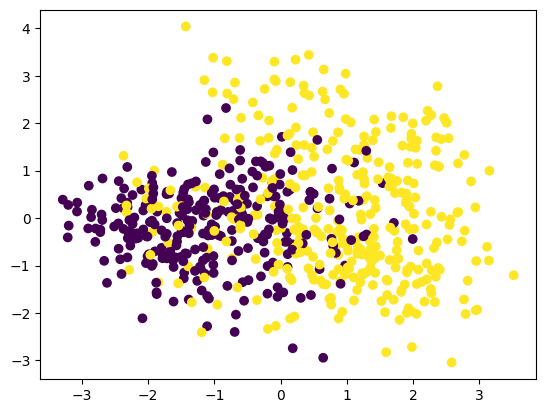

In [11]:
pc_train = pca.transform(X_num)
plt.scatter(pc_train[:, 0], pc_train[:, 1], c = train.HeartDisease)
plt.show()

**考察**

今回はヒストグラムに面白い特徴が見えています。

* `Sex`, `Cholesterol`, `FastingBS`, `MaxHR`, `ExerciseAngina`, `Oldpeak`はいずれも2峰性を持っている。特にどちらの峰に所属するかに、心臓病か否かで違いが見える。

例えば、`Cholesterol`では値が`0`の人に心臓病が多く、`0`より大きい場合には正常が多い様子が確認できます。これはラベルを予測するのになんらかの閾値が役に立つということです。そのような予測モデルには決定木モデルがありました。

#### 男性と女性で特徴量に差があるか？

`HeartDisease`の傾向に違いのある量的変数が、性別によって分布に違いがないかを調べる。

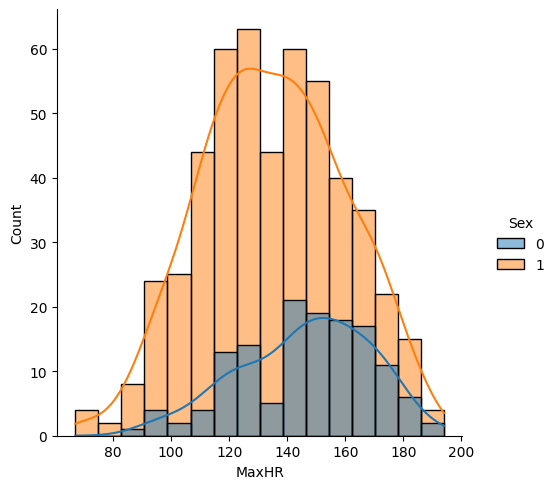

In [12]:
# MaxHRにおける性差
sns.displot(x = "MaxHR", data = train, hue = "Sex", kde = True)
plt.show()

**考察**
* 男性は女性に比べ、`MaxHR`が低い傾向にある。これが`HeartDisease`に影響？

#### UMAPによる可視化

UMAPやt-SNEによって2次元散布図に落とし込んだとき、いくつかのクラスターに分かれるようなことはないでしょうか。もしクラスターに分かれるのであれば、それが`HeartDisease`だったり、なにか別の質的変数になっていたりしないでしょうか。

In [13]:
# UMAPの前に、変数のスケールを揃えるためにRobustScalerを適用する。
scaler = RobustScaler()
umap_df = train.select_dtypes(exclude = "string").drop(["Sex", "HeartDisease"], axis = 1).copy()
umap_df = scaler.fit_transform(umap_df)

print("umap_dfのサイズ : ", umap_df.shape)

umap_dfのサイズ :  (642, 7)


In [14]:
# UMAPを適用
umap = UMAP(n_components = 2, n_neighbors = 5)
embedded = umap.fit_transform(umap_df)

print("embeddedのサイズ : ", embedded.shape)

embeddedのサイズ :  (642, 2)


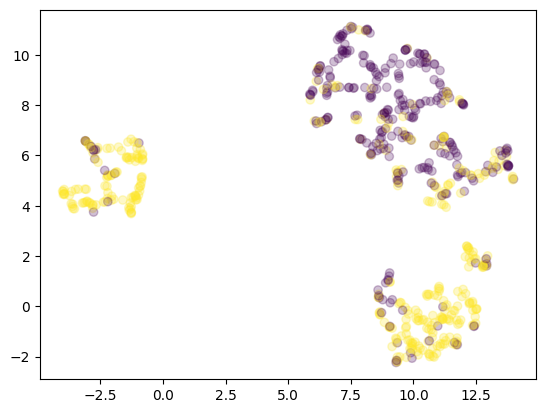

In [15]:
# 結果の可視化
plt.scatter(embedded[:, 0], embedded[:, 1], c = train.HeartDisease.values, alpha = 0.25)
plt.show()

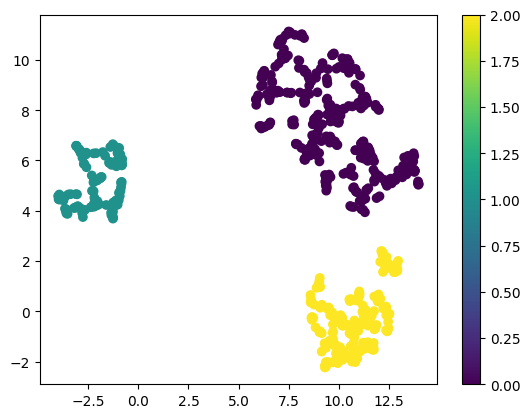

In [16]:
# k-means法でクラスターに分割
kmeans = KMeans(n_clusters = 3)
umap_cluster_id = kmeans.fit_predict(embedded)

plt.scatter(embedded[:, 0], embedded[:, 1], c = umap_cluster_id)
plt.colorbar()
plt.show()

In [17]:
train["umap_cluster_id"] = umap_cluster_id
train["umap_cluster_id"].value_counts()

0    329
2    190
1    123
Name: umap_cluster_id, dtype: int64

In [18]:
train.groupby("umap_cluster_id").mean()

Age       Sex   RestingBP  Cholesterol  FastingBS  \
umap_cluster_id                                                            
0                51.170213  0.693009  130.668693   240.392097   0.145897   
1                55.609756  0.926829  128.243902     0.000000   0.569106   
2                56.357895  0.857895  137.078947   248.647368   0.215789   

                      MaxHR  ExerciseAngina   Oldpeak  HeartDisease  
umap_cluster_id                                                      
0                147.662614        0.006079  0.452888      0.270517  
1                125.471545        0.495935  0.825203      0.902439  
2                127.336842        0.984211  1.644211      0.836842

In [19]:
(290*(1-0.213) + 229*0.812 + 123*0.902)/(290+229+123)

0.8179501557632399

In [20]:
train.groupby("umap_cluster_id").std()

Age       Sex  RestingBP  Cholesterol  FastingBS  \
umap_cluster_id                                                          
0                9.805186  0.461948  16.050120    61.875820   0.353540   
1                8.916401  0.261482  20.410678     0.000000   0.497227   
2                8.374079  0.350081  18.588529    55.284994   0.412456   

                     MaxHR  ExerciseAngina   Oldpeak  HeartDisease  
umap_cluster_id                                                     
0                23.569148        0.077849  0.774202      0.444903  
1                22.567322        0.502028  1.052678      0.297934  
2                19.645596        0.124990  1.150819      0.370486

**考察**

* UMAPの結果3つのクラスターができる。
    * 1つめは`ExerciseAngina`, `Oldpeak`が高いクラスター : 心臓病傾向が高い
    * 2つめは`Cholesterol`が低いクラスター : 心臓病傾向が高い
    * 3つめは`ExerciseAngina`が低い、`MaxHR`が高いクラスター: 心臓病傾向が低い/分類が難しめ
* 3つめのクラスターが、他のクラスターと区別が付きづらい。

### 分類が難しいクラスターで`HeartDisease`を分類する方法は？

`ExerciseAngina`が低いクラスターでは分類が難しい。

In [21]:
cluster0 = train.query("umap_cluster_id == 0")
cluster0.head(n = 5)

Age  Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
1   55    0           ATA        130          394          0        LVH   
4   54    0           NAP        160          201          0     Normal   
5   64    1           NAP        140          335          0     Normal   
6   65    1           ASY        135          254          0        LVH   
9   33    1           NAP        120          298          0     Normal   

   MaxHR  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  umap_cluster_id  
1    150               0      0.0       Up             0                0  
4    163               0      0.0       Up             0                0  
5    158               0      0.0       Up             1                0  
6    127               0      2.8     Flat             1                0  
9    185               0      0.0       Up             0                0

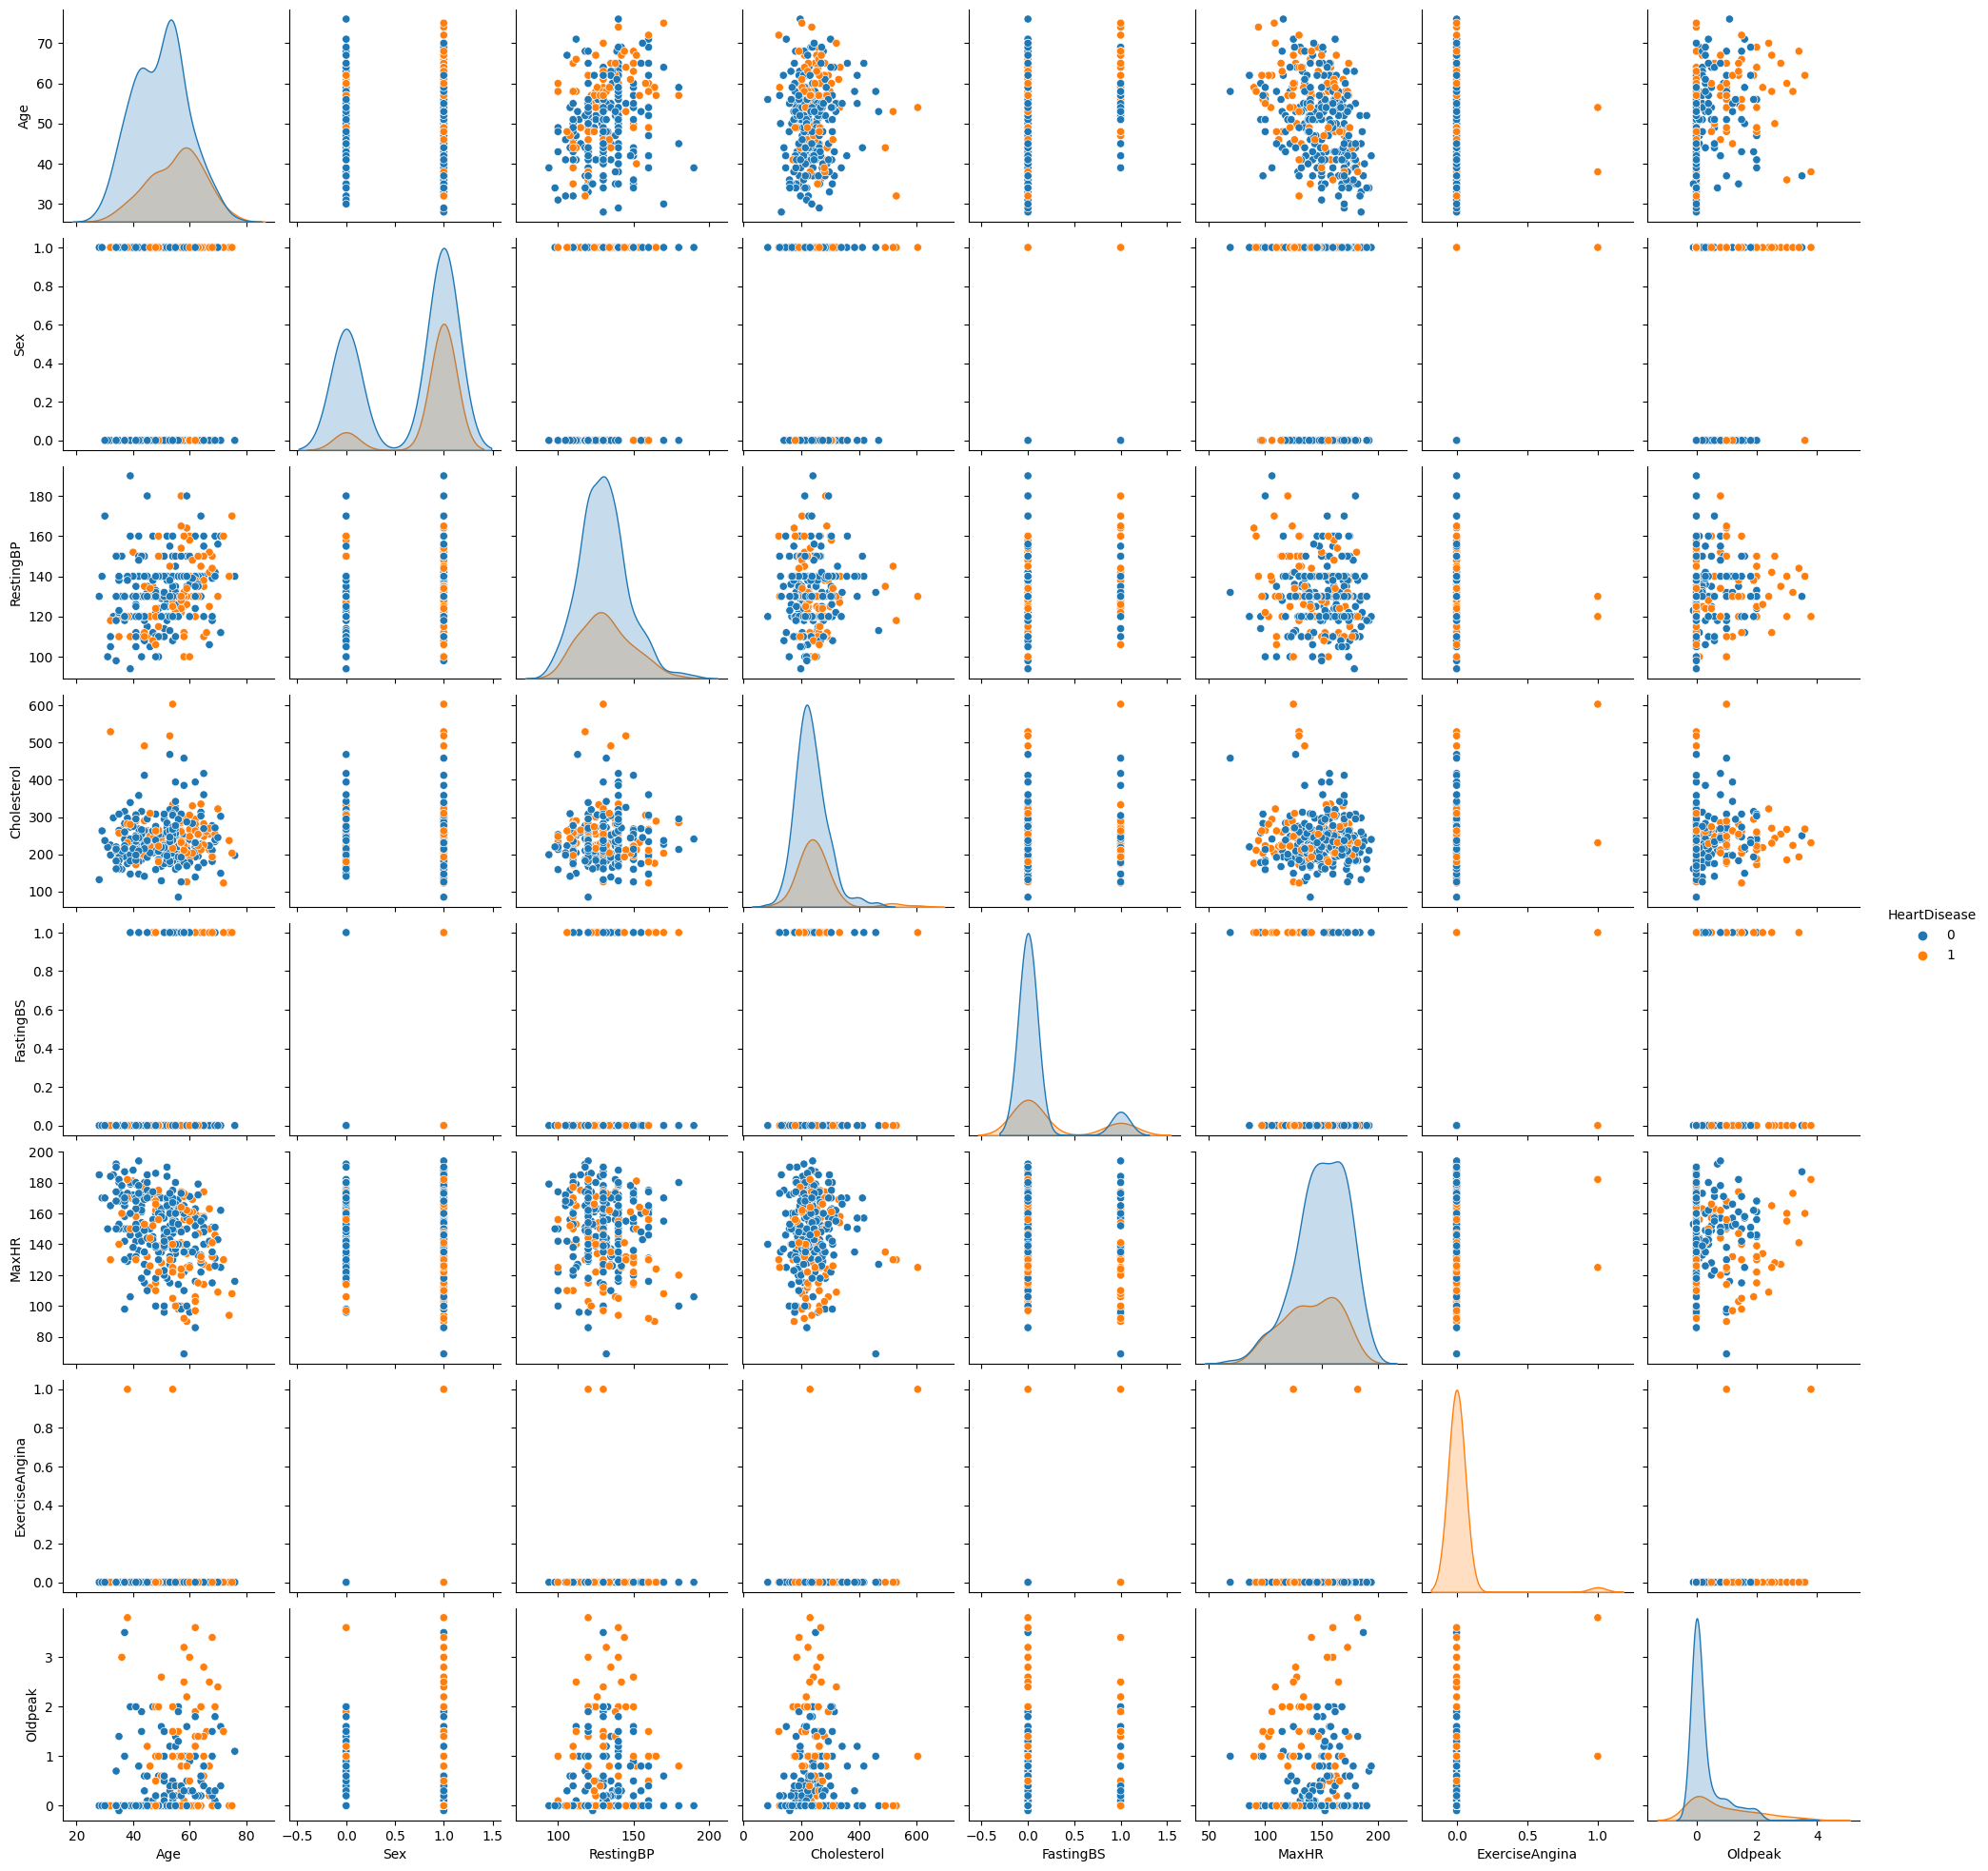

In [22]:
sns.pairplot(cluster0.drop("umap_cluster_id", axis = 1), hue = "HeartDisease")
plt.show()

`Sex`と`FastingBS`が分類に寄与するか？もっと良い特徴量はないか？

In [23]:
# ChestPainTypeの偏り
pd.crosstab(cluster0["ChestPainType"], cluster0["HeartDisease"], margins = "all")

HeartDisease     0   1  All
ChestPainType              
ASY             49  53  102
ATA             95  10  105
NAP             82  21  103
TA              14   5   19
All            240  89  329

In [24]:
# RestingECGの偏り
pd.crosstab(cluster0["RestingECG"], cluster0["HeartDisease"], margins = "all")

HeartDisease    0   1  All
RestingECG                
LVH            46  31   77
Normal        159  49  208
ST             35   9   44
All           240  89  329

In [25]:
# ST_Slopeの偏り : Flat or Upでうまく分類できそう
pd.crosstab(cluster0["ST_Slope"], cluster0["HeartDisease"], margins = "all")

HeartDisease    0   1  All
ST_Slope                  
Down            6   2    8
Flat           31  68   99
Up            203  19  222
All           240  89  329

### 質的変数と`HeartDisease`の関係

#### 質的変数と`HeartDisease`の間のクロス集計表

残る質的変数に対しては、`HeartDisease`とのクロス集計表をかいていきます。

In [26]:
# ChestPainTypeの偏り
pd.crosstab(train["ChestPainType"], train["HeartDisease"], margins = "all")

HeartDisease     0    1  All
ChestPainType               
ASY             69  281  350
ATA            105   17  122
NAP             95   54  149
TA              14    7   21
All            283  359  642

**考察**

* `ASY`に該当する場合、心臓病であることが多い。
* `ATA`に該当する場合、正常であることが多い。

In [27]:
# RestingECGの偏り
pd.crosstab(train["RestingECG"], train["HeartDisease"], margins = "all")

HeartDisease    0    1  All
RestingECG                 
LVH            52   69  121
Normal        187  210  397
ST             44   80  124
All           283  359  642

**考察**

* 大きな差は感じられない。

In [28]:
# ST_Slopeの偏り
pd.crosstab(train["ST_Slope"], train["HeartDisease"], margins = "all")

HeartDisease    0    1  All
ST_Slope                   
Down            9   40   49
Flat           51  265  316
Up            223   54  277
All           283  359  642

**考察**

* `Flat`, `Down`だと心臓病、`Up`だと正常であることが多い。

#### 質的変数間のクロス集計表

In [29]:
# 質的変数間の相関
pd.crosstab(train["ChestPainType"], train["ST_Slope"], margins = "all")

ST_Slope       Down  Flat  Up    All 
ChestPainType                        
ASY              39   222    89   350
ATA               3    22    97   122
NAP               7    63    79   149
TA                0     9    12    21
All              49   316   277   642

**考察**

* `ASY`かいなか・`Down`,`Flat`のどちらかに所属するかとの間には大きな相関がある。
    * この2つはいずれも心臓病である傾向が強い群


#### UMAPで作ったクラスターとの比較

In [30]:
# 質的変数間の相関
pd.crosstab(train["ChestPainType"], train["umap_cluster_id"], margins = "all")

umap_cluster_id    0    1    2  All
ChestPainType                      
ASY              102   94  154  350
ATA              105    6   11  122
NAP              103   21   25  149
TA                19    2    0   21
All              329  123  190  642

In [31]:
# 質的変数間の相関
pd.crosstab(train["ST_Slope"], train["umap_cluster_id"], margins = "all")

umap_cluster_id    0    1    2  All
ST_Slope                           
Down               8   15   26   49
Flat              99   75  142  316
Up               222   33   22  277
All              329  123  190  642

**考察**

* 量的変数で区別することが難しそうだったクラスターで`ChestPainType`, `ST_Slope`の傾向が異なる。
    * 特に`ChestPainType`ではほとんどが`ASY`に偏っている。
    * 実はこれらの変数は、`ExercisesAngina`と強い相関がある。

In [32]:
pd.crosstab(train["ChestPainType"], train["ExerciseAngina"], margins = "all")

ExerciseAngina    0    1  All
ChestPainType                
ASY             149  201  350
ATA             110   12  122
NAP             113   36  149
TA               20    1   21
All             392  250  642

In [33]:
pd.crosstab(train["ST_Slope"], train["ExerciseAngina"], margins = "all")

ExerciseAngina    0    1  All
ST_Slope                     
Down             15   34   49
Flat            132  184  316
Up              245   32  277
All             392  250  642

## D　ベンチマークモデルを作成する

今回は、以下の変数を入力変数としたLightGBMでベンチマークモデルを作成します。

### データの準備

In [34]:
# 特徴量
features = ["Sex", "Cholesterol", "FastingBS", "ExerciseAngina", "MaxHR", "Oldpeak", "ChestPainType", "ST_Slope"]
X_train, y_train = train[features].copy(), train["HeartDisease"].copy()
X_test, y_test = test[features].copy(), test["HeartDisease"].copy()

In [35]:
# LightGBMのためのラベルエンコーディング
encoder = LabelEncoder()
encoder.fit(train["ChestPainType"])

X_train["ChestPainType"] = encoder.transform(X_train["ChestPainType"])
X_test["ChestPainType"] = encoder.transform(X_test["ChestPainType"])

print("変換結果 : ", encoder.classes_)    # 左から順に0, 1, 2, 3

変換結果 :  ['ASY' 'ATA' 'NAP' 'TA']


In [36]:
# LightGBMのためのラベルエンコーディング
encoder = LabelEncoder()
encoder.fit(train["ST_Slope"])

X_train["ST_Slope"] = encoder.transform(X_train["ST_Slope"])
X_test["ST_Slope"] = encoder.transform(X_test["ST_Slope"])

print("変換結果 : ", encoder.classes_)    # 左から順に0, 1, 2

変換結果 :  ['Down' 'Flat' 'Up']


In [37]:
# early stoppingのためのデータを分割
X_learn, X_val, y_learn, y_val = train_test_split(X_train, y_train, 
                                                  test_size = 0.2)
X_learn, X_val = X_learn.copy(), X_val.copy()
y_learn, y_val = y_learn.copy(), y_val.copy()

print("学習データのサイズ : ", X_learn.shape)
print("検証データのサイズ : ", X_val.shape)

学習データのサイズ :  (513, 8)
検証データのサイズ :  (129, 8)


In [38]:
# early stoppingのためのデータを分割
X_learn, X_es, y_learn, y_es = train_test_split(X_learn, y_learn, 
                                                test_size = 0.2)
X_learn, X_es = X_learn.copy(), X_es.copy()
y_learn, y_es = y_learn.copy(), y_es.copy()

print("学習データのサイズ : ", X_learn.shape)
print("検証データのサイズ : ", X_es.shape)

学習データのサイズ :  (410, 8)
検証データのサイズ :  (103, 8)


### `LGBMClassifer`の設定

In [39]:
def objective(trial):
    num_leaves = trial.suggest_int("num_leaves", 2, 256)
    max_depth = trial.suggest_int("max_depth", 2, 8)
 
    lgbmc = LGBMClassifier(objective = "binary", 
                           num_iterations = 3000, 
                           num_leaves = num_leaves,
                           max_depth = max_depth,
                           learning_rate = 0.001)
    lgbmc.fit(X_learn, y_learn,
              eval_set = [(X_es, y_es)], 
              early_stopping_rounds = 10, 
              categorical_feature = ["ChestPainType", "ST_Slope"],
              verbose = 0)
    pred_val = lgbmc.predict(X_val)
    accuracy = accuracy_score(y_val, pred_val)
    return accuracy

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    study = optuna.create_study(direction = "maximize")
    study.optimize(objective, n_trials = 100)

    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)

Number of finished trials: 100
Best trial: {'num_leaves': 71, 'max_depth': 4}


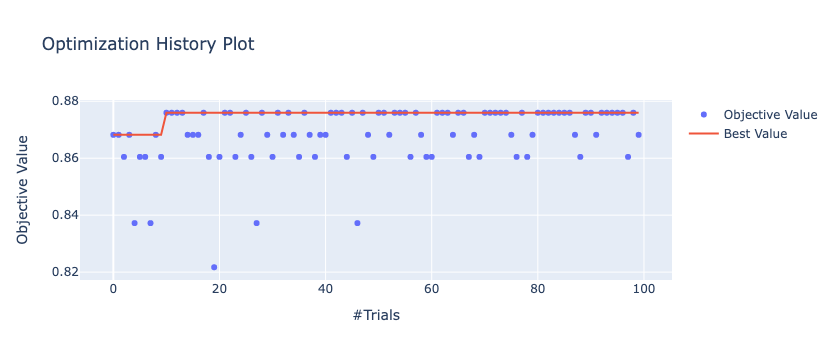

In [40]:
plot_optimization_history(study)

In [41]:
lgbmc = LGBMClassifier(objective = "binary", 
                       num_iterations = 3000, 
                       num_leaves = study.best_trial.params["num_leaves"],
                       max_depth = study.best_trial.params["max_depth"], 
                       learning_rate = 0.001)
lgbmc.fit(X_learn, y_learn,
          eval_set = [(X_val, y_val)], 
          early_stopping_rounds = 100, 
          categorical_feature = ["ChestPainType", "ST_Slope"],
          verbose = 300)

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_fea

[300]	valid_0's binary_logloss: 0.563481
[600]	valid_0's binary_logloss: 0.49225
[900]	valid_0's binary_logloss: 0.442823
[1200]	valid_0's binary_logloss: 0.401294
[1500]	valid_0's binary_logloss: 0.374453
[1800]	valid_0's binary_logloss: 0.356267
[2100]	valid_0's binary_logloss: 0.343647
[2400]	valid_0's binary_logloss: 0.336153
[2700]	valid_0's binary_logloss: 0.331427
[3000]	valid_0's binary_logloss: 0.327881


LGBMClassifier(learning_rate=0.001, max_depth=4, num_iterations=3000,
               num_leaves=71, objective='binary')

### 変数重要度

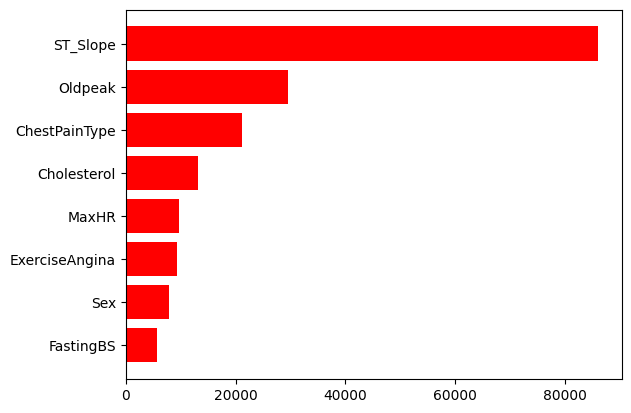

In [42]:
# 変数重要度（入力変数ごとに決定木分類の変数重要度の平均を取ったもの）
importances = lgbmc.booster_.feature_importance(importance_type = "gain")
indices = np.argsort(importances)
plt.barh(np.asarray(features)[indices], importances[indices],
         color="r", align="center")
plt.show()

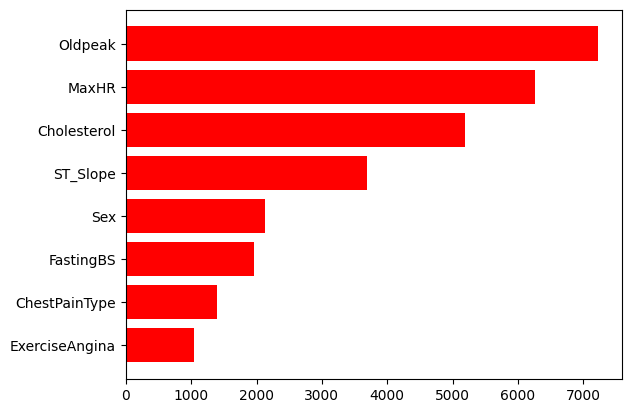

In [43]:
# 変数重要度（決定木のノードにその変数が現れた数の変数重要度として出す。）
importances = lgbmc.booster_.feature_importance(importance_type = "split")
indices = np.argsort(importances)
plt.barh(np.asarray(features)[indices], importances[indices],
         color="r", align="center")
plt.show()

### モデルの評価

In [44]:
pred_train, pred_test = lgbmc.predict(X_train), lgbmc.predict(X_test)

In [45]:
# 訓練データでの精度
print("混同行列 : \n", confusion_matrix(y_train, pred_train))
print("正答率 : ", accuracy_score(y_train, pred_train))

混同行列 : 
 [[253  30]
 [ 30 329]]
正答率 :  0.9065420560747663


In [46]:
# テストデータでの精度
print("混同行列 : \n", confusion_matrix(y_test, pred_test))
print("正答率 : ", accuracy_score(y_test, pred_test))

混同行列 : 
 [[101  26]
 [ 19 130]]
正答率 :  0.8369565217391305


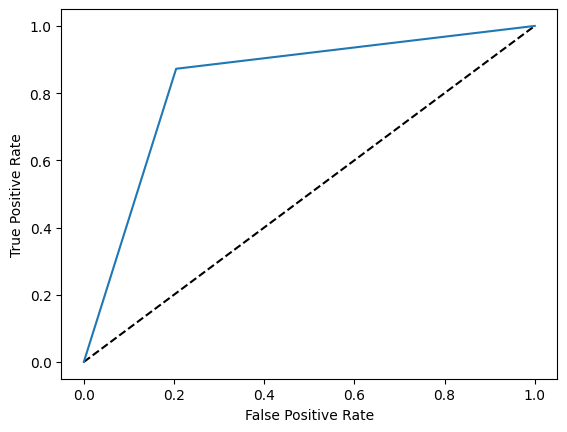

In [47]:
# テストデータにおけるROC曲線
fpr, tpr, _ = roc_curve(y_test, pred_test, pos_label = 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")    # 正常なものを異常と予測した割合
plt.ylabel("True Positive Rate")    # 異常なものを異常と予測した割合
plt.show()

In [48]:
# テストデータにおけるAUC
auc(fpr, tpr)

0.8338794060138456

#### どんなデータ点に対して予測を間違えているのか？

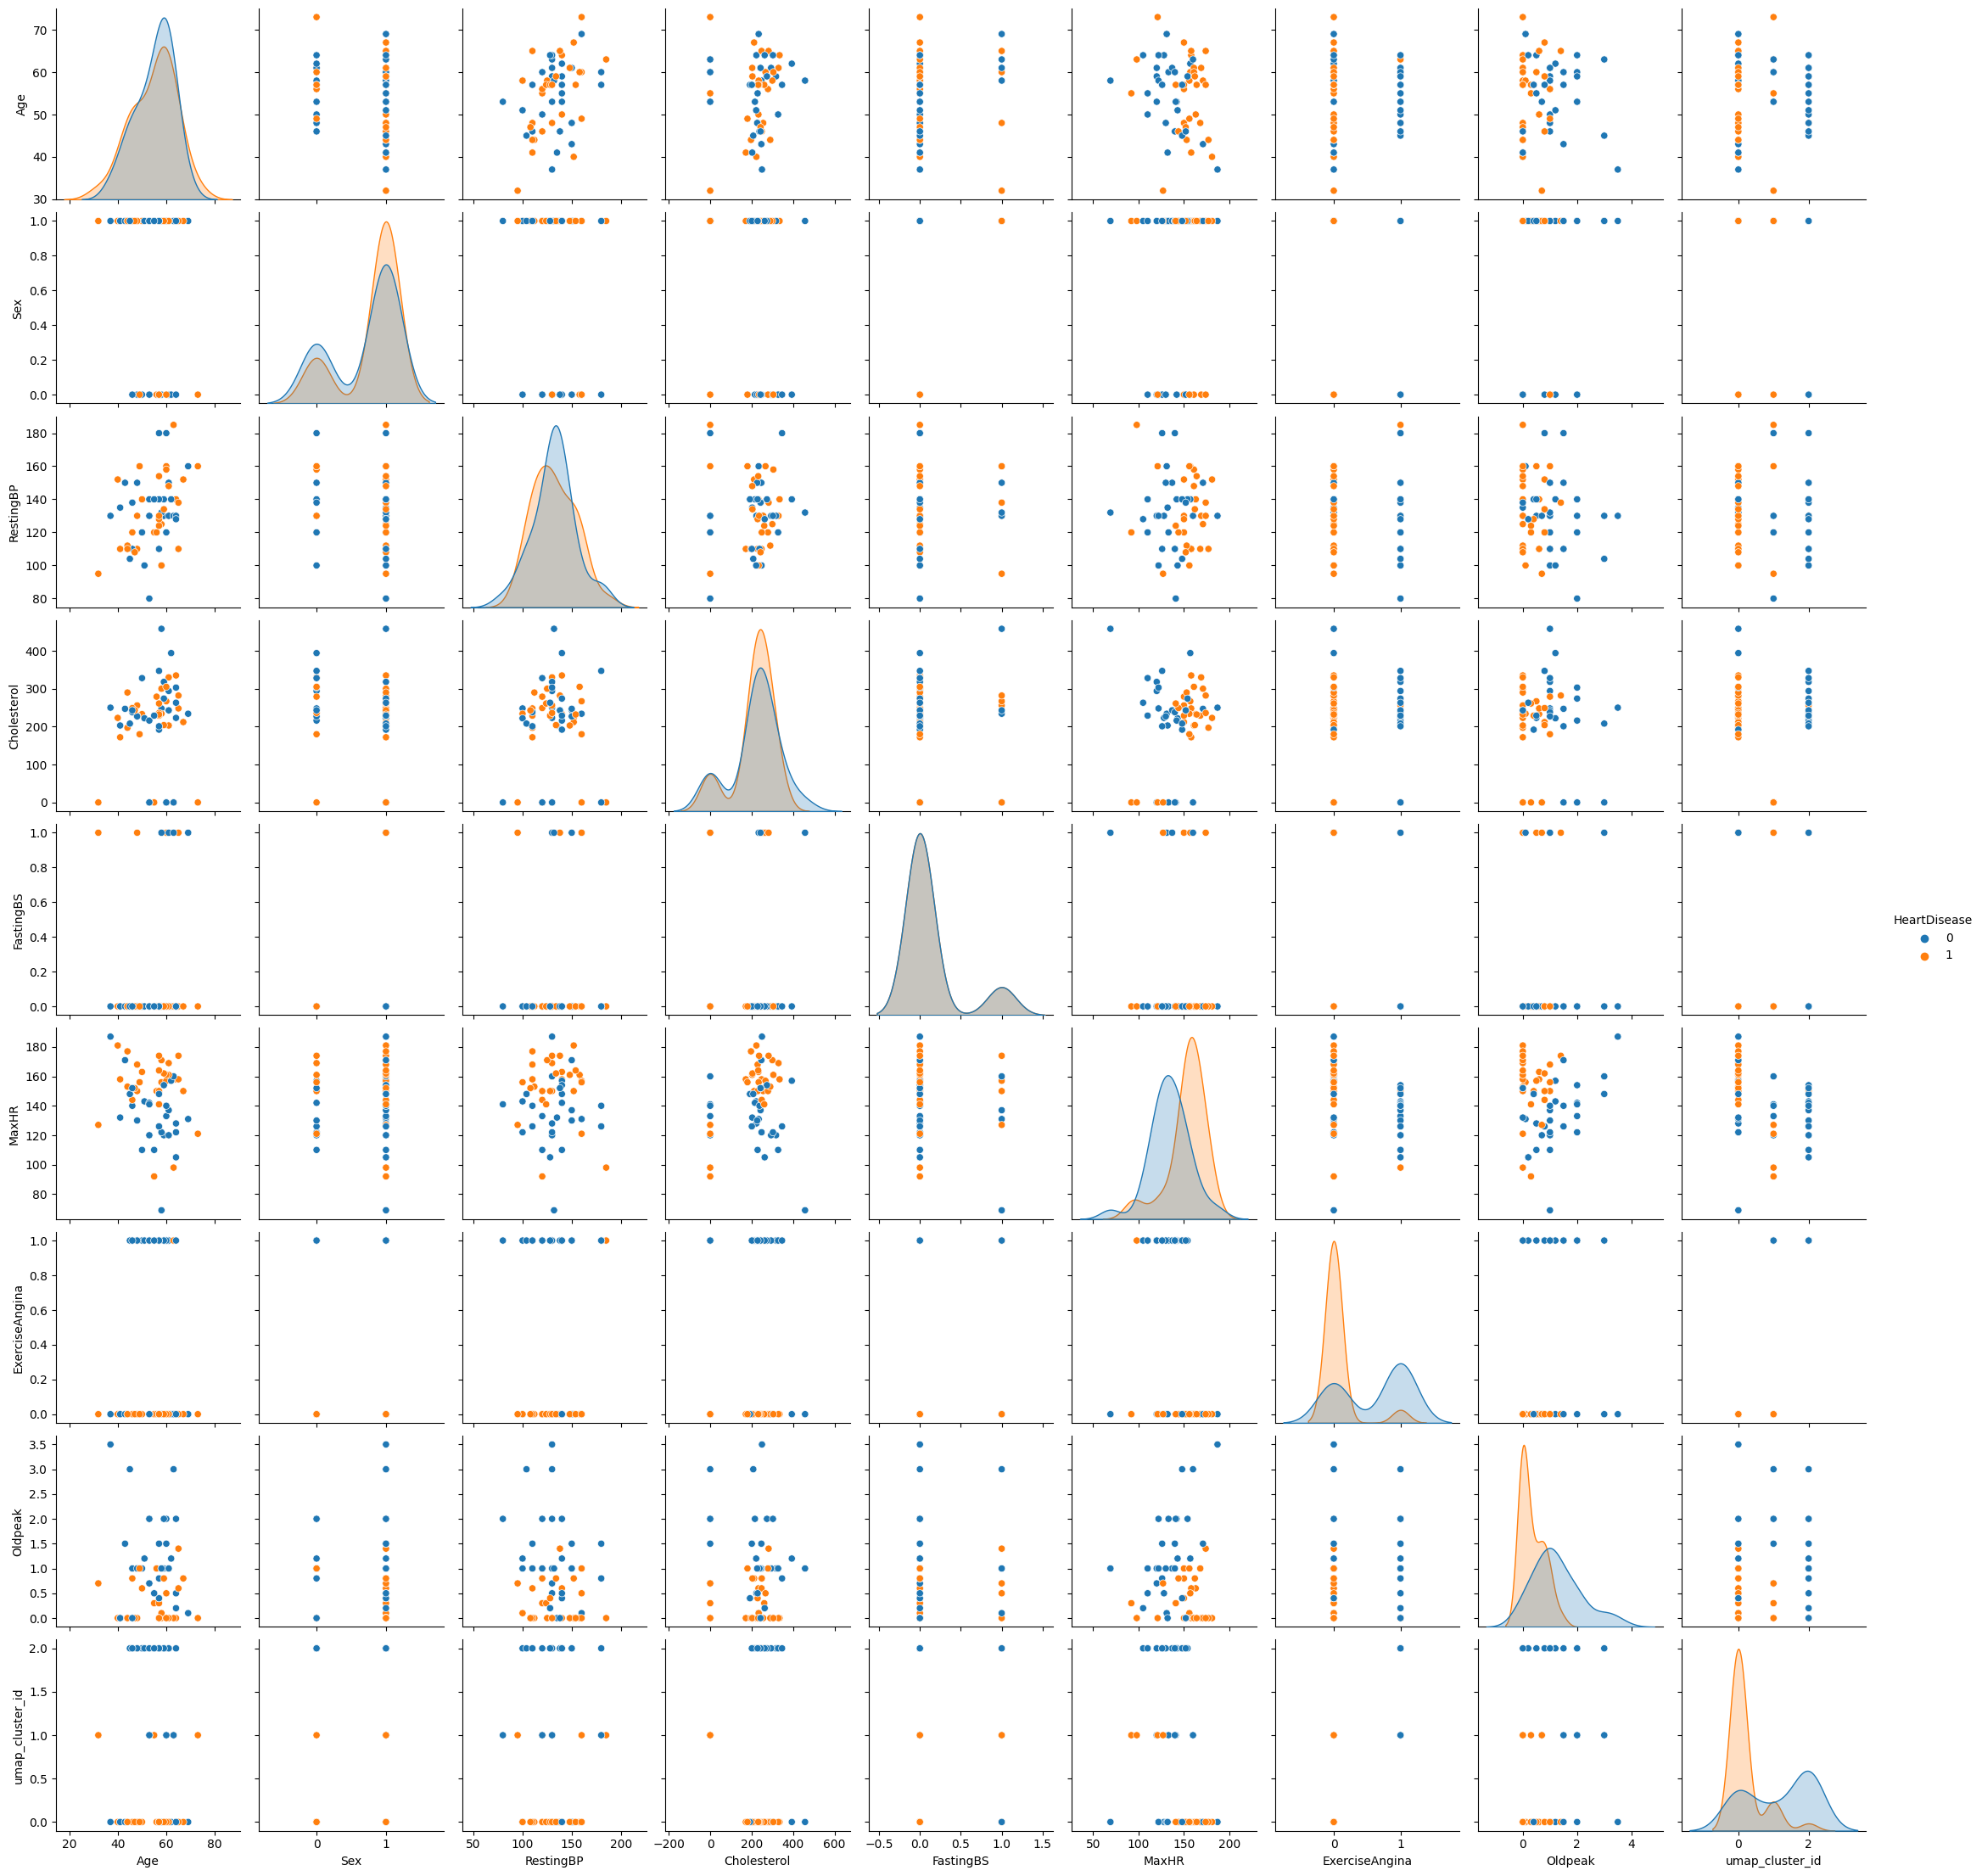

In [49]:
train_misclassif = train.loc[y_train != pred_train, :]
sns.pairplot(train_misclassif, hue = "HeartDisease")
plt.show()

**考察**

* `FastingBS`, `MaxHR`, `ExerciseAngina`に見られる心臓病の有無の違いが捉えられていない。
* `MaxHR`, `Oldpeak`を入力した割には、あまりうまく分類に寄与していない。

In [50]:
# 誤分類したクラスター
print(train.umap_cluster_id.value_counts())
print(train.umap_cluster_id.loc[y_train != pred_train].value_counts())

0    329
2    190
1    123
Name: umap_cluster_id, dtype: int64
0    35
2    16
1     9
Name: umap_cluster_id, dtype: int64


## E　モデル改善

**改善策**　
* `MaxHR`を抜いて、`Sex`を入れてみよう。
* `FastingBS`を入れてみよう。

### データの準備

In [51]:
# 特徴量
features = ["Sex", "Cholesterol", "ExerciseAngina", "FastingBS", "ChestPainType", "Oldpeak", "ST_Slope"]
X_train, y_train = train[features].copy(), train["HeartDisease"].copy()
X_test, y_test = test[features].copy(), test["HeartDisease"].copy()

In [52]:
# LightGBMのためのラベルエンコーディング
encoder = LabelEncoder()
encoder.fit(train["ChestPainType"])

X_train["ChestPainType"] = encoder.transform(X_train["ChestPainType"])
X_test["ChestPainType"] = encoder.transform(X_test["ChestPainType"])

print("変換結果 : ", encoder.classes_)    # 左から順に0, 1, 2, 3

変換結果 :  ['ASY' 'ATA' 'NAP' 'TA']


In [53]:
# LightGBMのためのラベルエンコーディング
encoder = LabelEncoder()
encoder.fit(train["ST_Slope"])

X_train["ST_Slope"] = encoder.transform(X_train["ST_Slope"])
X_test["ST_Slope"] = encoder.transform(X_test["ST_Slope"])

print("変換結果 : ", encoder.classes_)    # 左から順に0, 1, 2

変換結果 :  ['Down' 'Flat' 'Up']


In [54]:
# early stoppingのためのデータを分割
X_learn, X_val, y_learn, y_val = train_test_split(X_train, y_train, 
                                                  test_size = 0.2)
X_learn, X_val = X_learn.copy(), X_val.copy()
y_learn, y_val = y_learn.copy(), y_val.copy()

print("学習データのサイズ : ", X_learn.shape)
print("検証データのサイズ : ", X_val.shape)

学習データのサイズ :  (513, 7)
検証データのサイズ :  (129, 7)


In [55]:
# early stoppingのためのデータを分割
X_learn, X_es, y_learn, y_es = train_test_split(X_learn, y_learn, 
                                                test_size = 0.2)
X_learn, X_es = X_learn.copy(), X_es.copy()
y_learn, y_es = y_learn.copy(), y_es.copy()

print("学習データのサイズ : ", X_learn.shape)
print("検証データのサイズ : ", X_es.shape)

学習データのサイズ :  (410, 7)
検証データのサイズ :  (103, 7)


### `LGBMClassifier`の設定

In [56]:
def objective(trial):
    num_leaves = trial.suggest_int("num_leaves", 2, 256)
    max_depth = trial.suggest_int("max_depth", 2, 8)
 
    lgbmc = LGBMClassifier(objective = "binary", 
                           num_iterations = 3000, 
                           num_leaves = num_leaves,
                           max_depth = max_depth,
                           learning_rate = 0.001)
    lgbmc.fit(X_learn, y_learn,
              eval_set = [(X_es, y_es)], 
              early_stopping_rounds = 10, 
              categorical_feature = ["ChestPainType"],#, "ST_Slope"],
              verbose = 0)
    pred_val = lgbmc.predict(X_val)
    accuracy = accuracy_score(y_val, pred_val)
    return accuracy

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    study = optuna.create_study(direction = "maximize")
    study.optimize(objective, n_trials = 100)

    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)

Number of finished trials: 100
Best trial: {'num_leaves': 3, 'max_depth': 2}


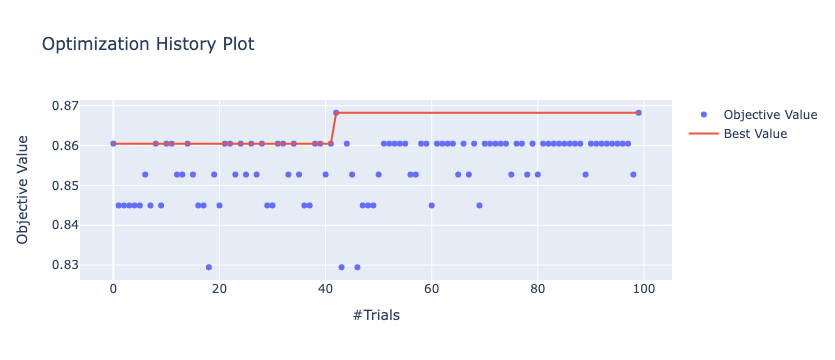

In [57]:
plot_optimization_history(study)

In [58]:
lgbmc = LGBMClassifier(objective = "binary", 
                       num_iterations = 3000, 
                       num_leaves = study.best_trial.params["num_leaves"],
                       max_depth = study.best_trial.params["max_depth"], 
                       learning_rate = 0.001)
lgbmc.fit(X_learn, y_learn,
          eval_set = [(X_val, y_val)], 
          early_stopping_rounds = 10, 
          categorical_feature = ["ChestPainType", "ST_Slope"],
          verbose = 300)

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_fea

[300]	valid_0's binary_logloss: 0.594085
[600]	valid_0's binary_logloss: 0.526502
[900]	valid_0's binary_logloss: 0.474127
[1200]	valid_0's binary_logloss: 0.438822
[1500]	valid_0's binary_logloss: 0.415091
[1800]	valid_0's binary_logloss: 0.397445
[2100]	valid_0's binary_logloss: 0.383148
[2400]	valid_0's binary_logloss: 0.372311
[2700]	valid_0's binary_logloss: 0.36353
[3000]	valid_0's binary_logloss: 0.356336


LGBMClassifier(learning_rate=0.001, max_depth=2, num_iterations=3000,
               num_leaves=3, objective='binary')

### 変数重要度

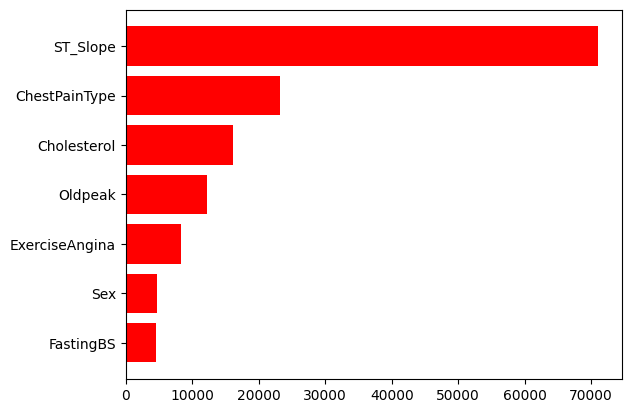

In [59]:
# 変数重要度（入力変数ごとに決定木回帰の変数重要度の平均を取ったもの）
importances = lgbmc.booster_.feature_importance(importance_type = "gain")
indices = np.argsort(importances)
plt.barh(np.asarray(features)[indices], importances[indices],
         color="r", align="center")
plt.show()

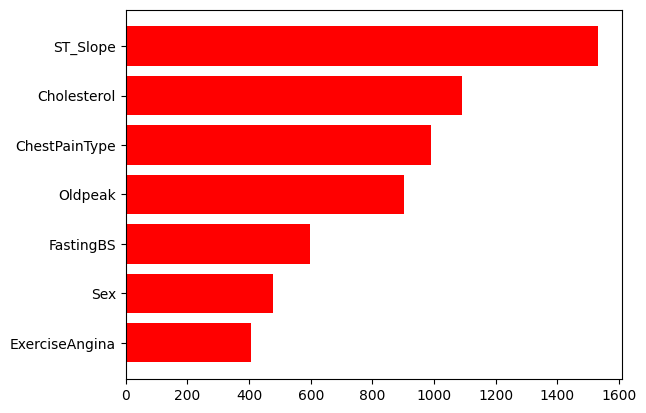

In [60]:
# 変数重要度（決定木のノードにその変数が現れた数の変数重要度として出す。）
importances = lgbmc.booster_.feature_importance(importance_type = "split")
indices = np.argsort(importances)
plt.barh(np.asarray(features)[indices], importances[indices],
         color="r", align="center")
plt.show()

### モデルの評価

In [61]:
pred_train, pred_test = lgbmc.predict(X_train), lgbmc.predict(X_test)

In [62]:
# 訓練データでの精度
print("混同行列 : \n", confusion_matrix(y_train, pred_train))
print("正答率 : ", accuracy_score(y_train, pred_train))

混同行列 : 
 [[231  52]
 [ 24 335]]
正答率 :  0.881619937694704


In [63]:
# テストデータでの精度
print("混同行列 : \n", confusion_matrix(y_test, pred_test))
print("正答率 : ", accuracy_score(y_test, pred_test))

混同行列 : 
 [[ 98  29]
 [ 11 138]]
正答率 :  0.855072463768116


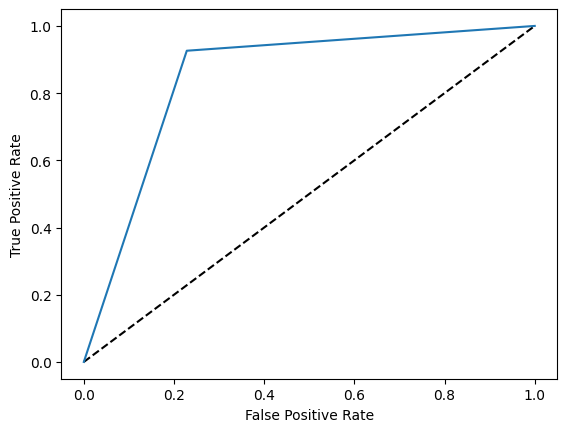

In [64]:
# テストデータにおけるROC曲線
fpr, tpr, _ = roc_curve(y_test, pred_test, pos_label = 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")    # 正常なものを異常と予測した割合
plt.ylabel("True Positive Rate")    # 異常なものを異常と予測した割合
plt.show()

In [65]:
# テストデータにおけるAUC
auc(fpr, tpr)

0.8489140199756909

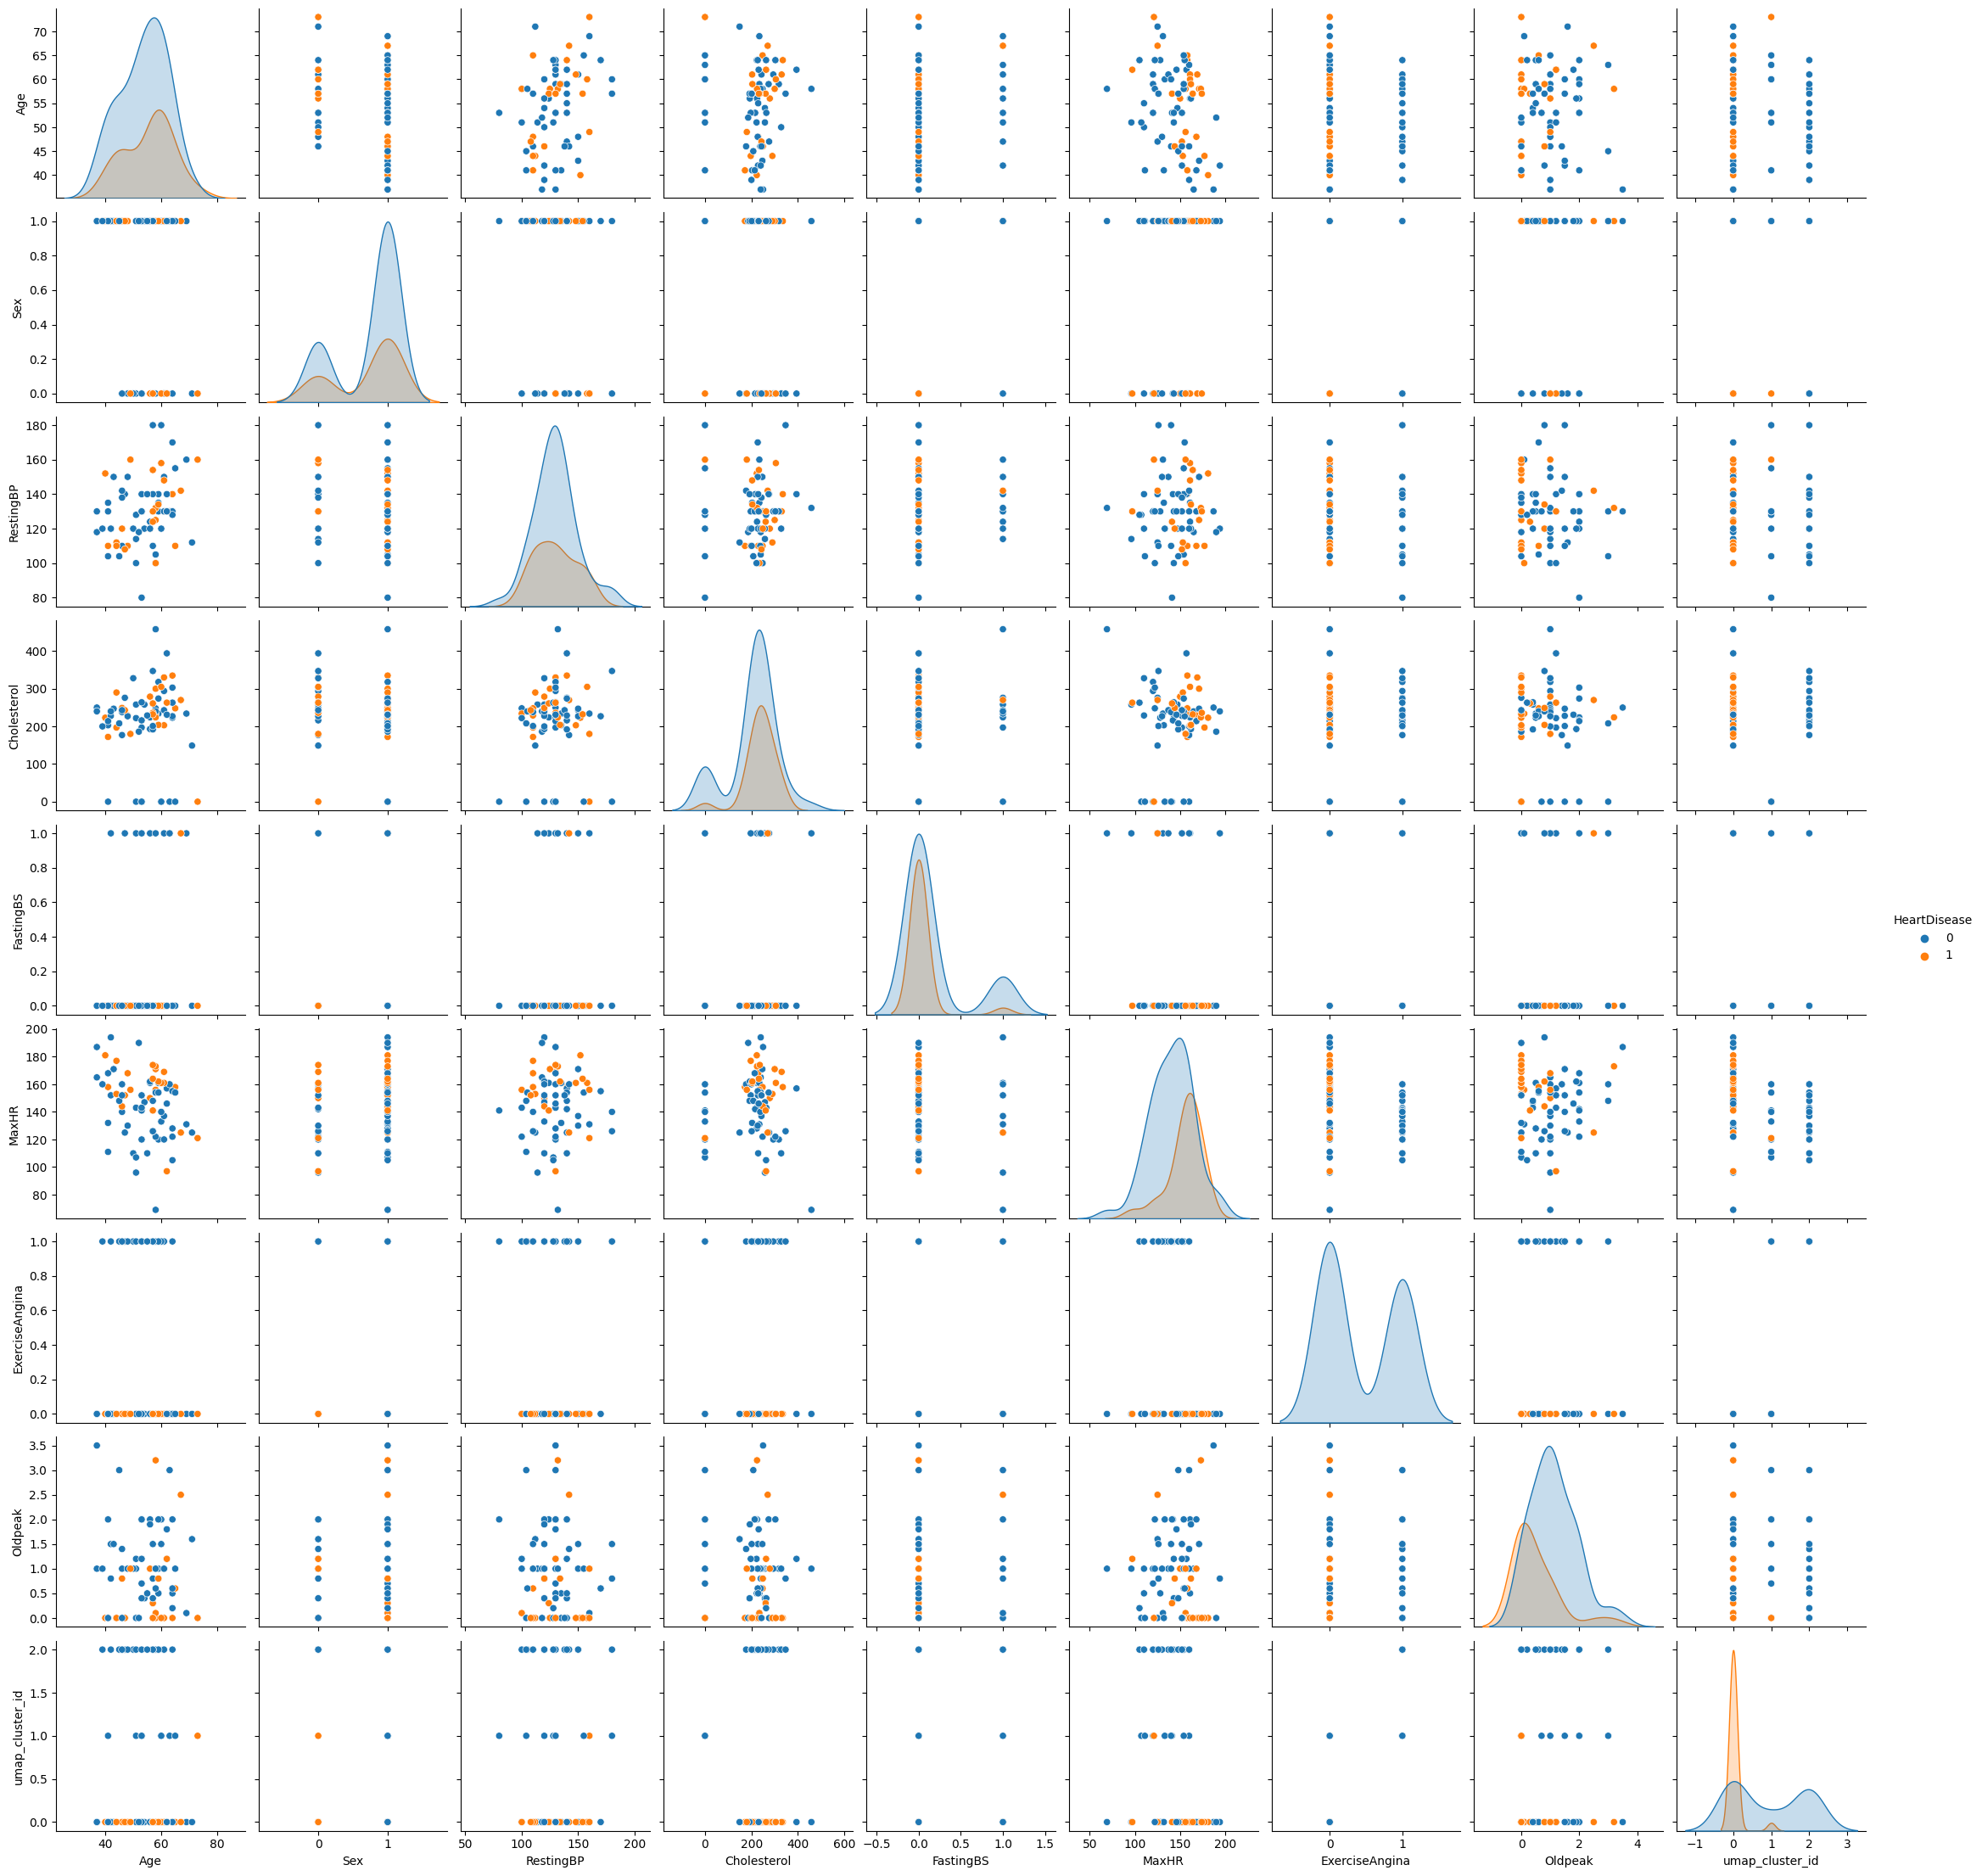

In [66]:
train_misclassif = train.loc[y_train != pred_train, :]
sns.pairplot(train_misclassif, hue = "HeartDisease")
plt.show()

**やっていないこと**

* 実は`transformer`と相性がよいのではと思う部分があったが試していない。
* `SHAP`などを用いて予測の傾向を可視化して、想定したパターンが尽くされているか確認したほうがよい。
* もう少し誤分類したデータについてよく検討したほうが良かった。

## Appendix　そのままLightGBMを行う場合

In [67]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [68]:
# 特徴量
X_train, y_train = train.drop(["HeartDisease"], axis = 1).copy(), train["HeartDisease"].copy()
X_test, y_test = test.drop("HeartDisease", axis = 1).copy(), test["HeartDisease"].copy()

In [69]:
features = X_train.columns.tolist()
features

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope']

In [70]:
# LightGBMのためのラベルエンコーディング
encoder = LabelEncoder()
encoder.fit(train["ChestPainType"])

X_train["ChestPainType"] = encoder.transform(X_train["ChestPainType"])
X_test["ChestPainType"] = encoder.transform(X_test["ChestPainType"])

print("変換結果 : ", encoder.classes_)    # 左から順に0, 1, 2, 3

変換結果 :  ['ASY' 'ATA' 'NAP' 'TA']


In [71]:
# LightGBMのためのラベルエンコーディング
encoder = LabelEncoder()
encoder.fit(train["ST_Slope"])

X_train["ST_Slope"] = encoder.transform(X_train["ST_Slope"])
X_test["ST_Slope"] = encoder.transform(X_test["ST_Slope"])

print("変換結果 : ", encoder.classes_)    # 左から順に0, 1, 2, 3

変換結果 :  ['Down' 'Flat' 'Up']


In [72]:
# LightGBMのためのラベルエンコーディング
encoder = LabelEncoder()
encoder.fit(train["RestingECG"])

X_train["RestingECG"] = encoder.transform(X_train["RestingECG"])
X_test["RestingECG"] = encoder.transform(X_test["RestingECG"])

print("変換結果 : ", encoder.classes_)    # 左から順に0, 1, 2, 3

変換結果 :  ['LVH' 'Normal' 'ST']


In [73]:
# early stoppingのためのデータを分割
X_learn, X_val, y_learn, y_val = train_test_split(X_train, y_train, 
                                                  test_size = 0.2)
X_learn, X_val = X_learn.copy(), X_val.copy()
y_learn, y_val = y_learn.copy(), y_val.copy()

print("学習データのサイズ : ", X_learn.shape)
print("検証データのサイズ : ", X_val.shape)

学習データのサイズ :  (513, 11)
検証データのサイズ :  (129, 11)


In [74]:
# early stoppingのためのデータを分割
X_learn, X_es, y_learn, y_es = train_test_split(X_learn, y_learn, 
                                                test_size = 0.2)
X_learn, X_es = X_learn.copy(), X_es.copy()
y_learn, y_es = y_learn.copy(), y_es.copy()

print("学習データのサイズ : ", X_learn.shape)
print("検証データのサイズ : ", X_es.shape)

学習データのサイズ :  (410, 11)
検証データのサイズ :  (103, 11)


In [75]:
def objective(trial):
    num_leaves = trial.suggest_int("num_leaves", 2, 256)
    max_depth = trial.suggest_int("max_depth", 2, 8)
 
    lgbmc = LGBMClassifier(objective = "binary", 
                           num_iterations = 3000, 
                           num_leaves = num_leaves,
                           max_depth = max_depth,
                           learning_rate = 0.001)
    lgbmc.fit(X_learn, y_learn,
              eval_set = [(X_es, y_es)], 
              early_stopping_rounds = 10, 
              categorical_feature = ["ChestPainType", "ST_Slope"],
              verbose = 0)
    pred_val = lgbmc.predict(X_val)
    accuracy = accuracy_score(y_val, pred_val)
    return accuracy

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    study = optuna.create_study(direction = 'maximize')
    study.optimize(objective, n_trials = 10)

    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)

Number of finished trials: 10
Best trial: {'num_leaves': 7, 'max_depth': 7}


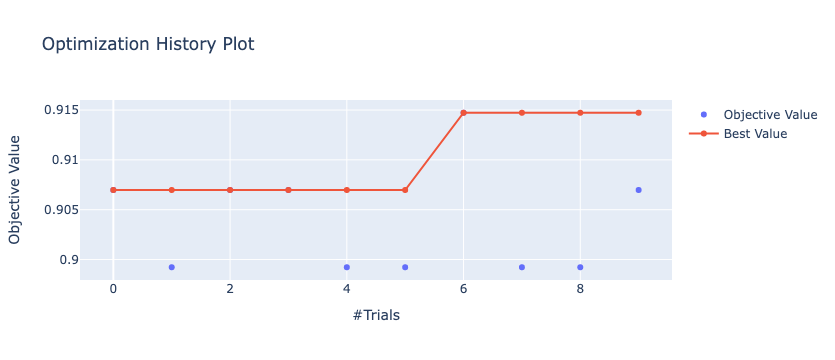

In [76]:
plot_optimization_history(study)

In [77]:
lgbmc = LGBMClassifier(objective = "binary", 
                       num_iterations = 3000, 
                       num_leaves = study.best_trial.params["num_leaves"],
                       max_depth = study.best_trial.params["max_depth"], 
                       learning_rate = 0.001)
lgbmc.fit(X_learn, y_learn,
          eval_set = [(X_val, y_val)], 
          early_stopping_rounds = 10, 
          categorical_feature = ["ChestPainType", "ST_Slope", "RestingECG"],
          verbose = 300)

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/lightgbm/basic.py:2068: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_fea

[300]	valid_0's binary_logloss: 0.55377
[600]	valid_0's binary_logloss: 0.476781
[900]	valid_0's binary_logloss: 0.425604
[1200]	valid_0's binary_logloss: 0.387374
[1500]	valid_0's binary_logloss: 0.362994
[1800]	valid_0's binary_logloss: 0.344655
[2100]	valid_0's binary_logloss: 0.331067
[2400]	valid_0's binary_logloss: 0.314495
[2700]	valid_0's binary_logloss: 0.300755
[3000]	valid_0's binary_logloss: 0.290881


LGBMClassifier(learning_rate=0.001, max_depth=7, num_iterations=3000,
               num_leaves=7, objective='binary')

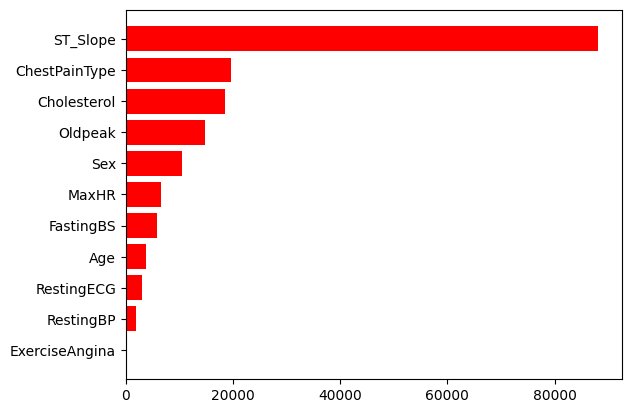

In [78]:
# 変数重要度（入力変数ごとに決定木回帰の変数重要度の平均を取ったもの）
importances = lgbmc.booster_.feature_importance(importance_type = "gain")
indices = np.argsort(importances)
plt.barh(np.asarray(features)[indices], importances[indices],
         color="r", align="center")
plt.show()

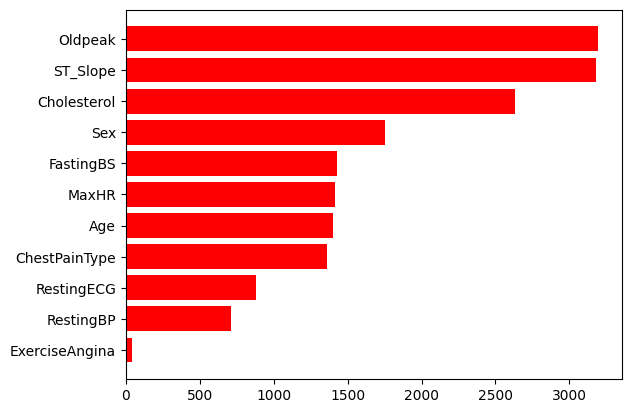

In [79]:
# 変数重要度（決定木のノードにその変数が現れた数の変数重要度として出す。）
importances = lgbmc.booster_.feature_importance(importance_type = "split")
indices = np.argsort(importances)
plt.barh(np.asarray(features)[indices], importances[indices],
         color="r", align="center")
plt.show()

In [80]:
pred_train, pred_test = lgbmc.predict(X_train), lgbmc.predict(X_test)

In [81]:
# 訓練データでの精度
print("混同行列 : \n", confusion_matrix(y_train, pred_train))
print("正答率 : ", accuracy_score(y_train, pred_train))

混同行列 : 
 [[244  39]
 [ 22 337]]
正答率 :  0.9049844236760125


In [82]:
# テストデータでの精度
print("混同行列 : \n", confusion_matrix(y_test, pred_test))
print("正答率 : ", accuracy_score(y_test, pred_test))

混同行列 : 
 [[100  27]
 [ 14 135]]
正答率 :  0.8514492753623188


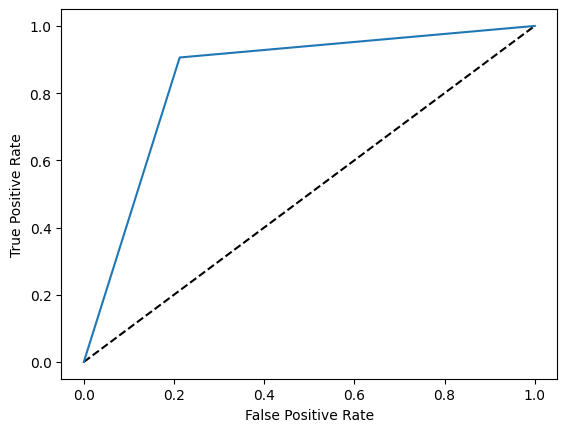

In [83]:
# テストデータにおけるROC曲線
fpr, tpr, _ = roc_curve(y_test, pred_test, pos_label = 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")    # 正常なものを異常と予測した割合
plt.ylabel("True Positive Rate")    # 異常なものを異常と予測した割合
plt.show()

In [84]:
auc(fpr, tpr)

0.8467209216297626

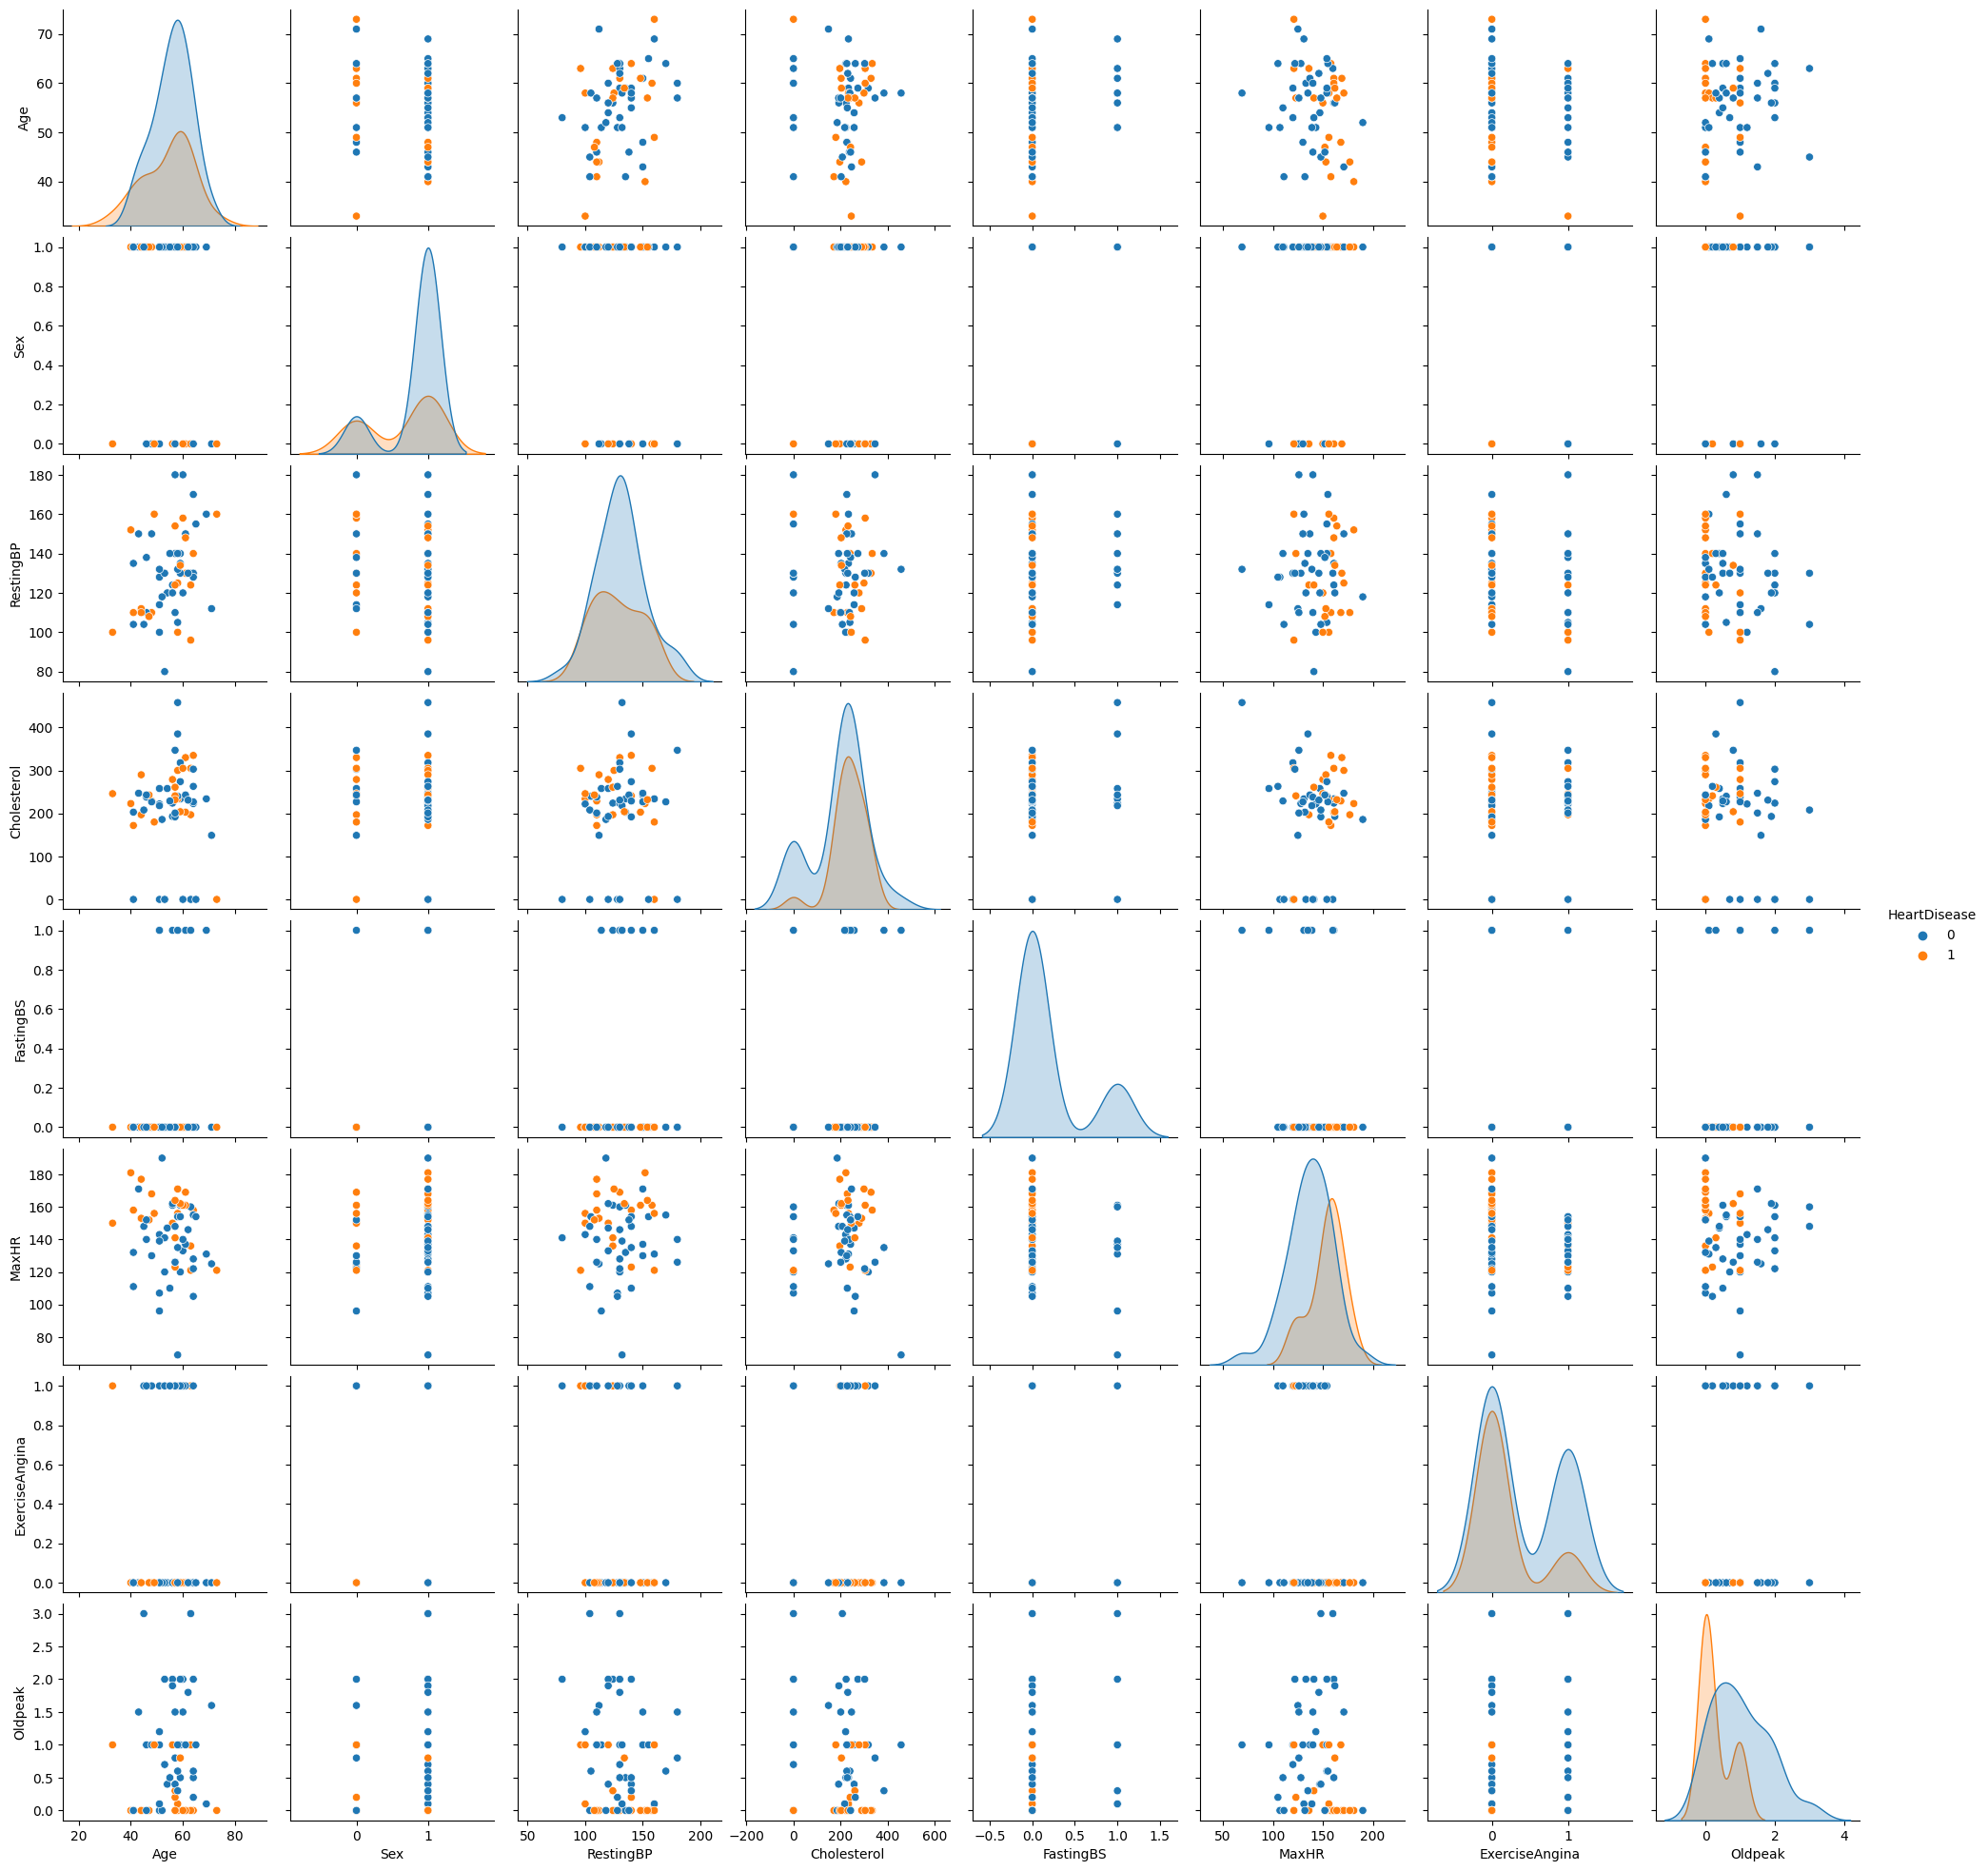

In [85]:
train_misclassif = train.loc[y_train != pred_train, :]
sns.pairplot(train_misclassif, hue = "HeartDisease")
plt.show()